## Inversion for a coupled acoustic-gravity system

Before running `pip install tinyda ray' 

### Problem setup

Let $\varphi$ be the potential for the flow velocity, it is solution to 
\begin{align}\label{eq:forwardmodel}
    \frac{\partial^2 \varphi}{\partial t^2}
    - c^2 \Delta \varphi 
    + g \frac{\partial \varphi}{\partial z}
    = 0,  \quad \text{ in } \Omega,
    \\
    \frac{\partial^2 \varphi}{\partial t^2}
    + g \frac{\partial \varphi}{\partial z} 
    = 0, \quad \text{ on } \Gamma_s,
    \\
    \nabla \varphi \cdot {\bf n}
    = u_b, \quad \text{ on } \Gamma_b,
\end{align}
where $c$ is the (constant) sound speed, $g$ is the gravity acceleration, ${\bf n}$ is the outwards unit vector normal to the seabed $\Gamma_b$ and $u_b$ is the seabed velocity.
The fluid displacement $u$ is related to the potential by $u = \nabla \varphi$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

import pandas as pd
import tinyDA as tda
import umbridge

Ray module not found. Multiprocessing features are not available
Ray module not found. Multiprocessing features are not available


### Initialising UM-Bridge
Before running the following cell, the model Docker image must be started from a system terminal using

`docker run -it -p 4242:4242 acousticgravity`

The Dockerfile can be found in the acousticgracity branch on UM-Bridge benchmarks. If not just running on a local machine replace `localhost` with the server.

In [35]:
# Create the config data
#### Change captor location and number
# Each element of the list "captors" is a tuple of (x,z) coordinates. 
# // version without PML: x should be between 6 and 36, z should be between 0 and (strictly less than) 1. 
# // version with PML: x should be between 1 and 29, z should be between 0 and (strictly less than) 1. 
captors = [(10,0.5), (18,0.9)] #[(28,0.5), (20,0.9)]

# Do not change this part 
captors = np.array(captors, dtype=[('x',float),('y',float)])
captors = np.sort(captors, order=['x','y'])
Lx = 20

In [36]:
# connect to the UM-Bridge model.
umbridge_model = umbridge.HTTPModel('http://localhost:4242', "forward")

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.
config={"captors":captors}
my_model = tda.UmBridgeModel(umbridge_model)

In [37]:
nx = umbridge_model.get_input_sizes()[0] #the input is the value of f(x) at each grid point
ny = umbridge_model.get_output_sizes()[0] #the outout is a time series of the pressure
print(f"input:{nx}, output:{ny}")

input:100, output:100


### Example of input creation

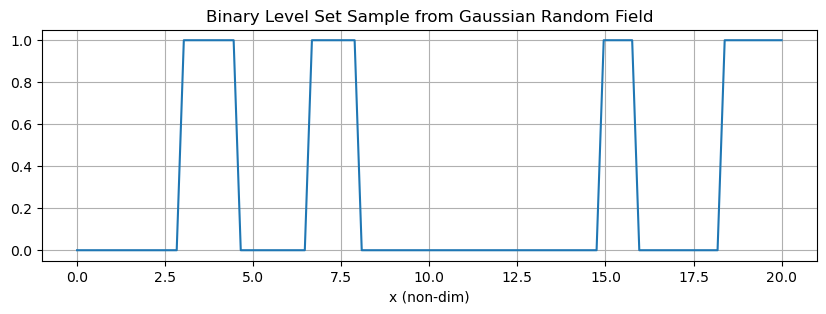

In [38]:
# Create level set of Gaussian random field
# TODO: how to scale / choose lenght_scale and decay_rate appropriately for a given domain size?
# GRF parameters
length_scale = 1
decay_rate = 10

# Level-set parameter
eps = 1e-6

Nx = 100
dx = Lx/Nx
x = np.linspace(0, Lx, Nx).reshape(-1, 1)

def rbf_covariance(grid, length_scale, variance=1.0):
    dists = cdist(grid, grid, 'euclidean')
    return variance * np.exp(-0.5 * (dists / length_scale) ** 2)

cov = rbf_covariance(x, length_scale)
cov += eps * np.eye(Nx)
mean = np.zeros(Nx)
my_prior = multivariate_normal(mean=mean, cov=cov)
sample = my_prior.rvs()

def restriction(sampin):
    field_cut = sampin
    return (field_cut > eps).astype(int)

sample = restriction(sample)

fig, ax = plt.subplots(figsize=(10, 3))
ax.grid()

ax.plot(x, sample)
ax.set_title("Binary Level Set Sample from Gaussian Random Field")
ax.set_xlabel("x (non-dim)")
plt.show()

In [39]:
sample

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Problem setup

In [51]:
# Generate synthetic data
exact = np.zeros(Nx)
# Should be between 0 and Nx
exact[20:30]=1
print(exact)
d_true = my_model(exact)

# add some noise to the model output
sigma_noise = 0.01
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


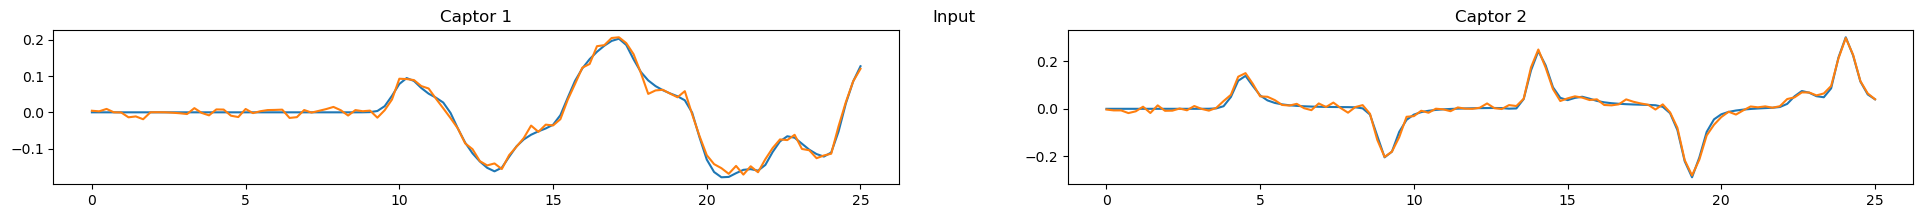

In [6]:
fig, ax = plt.subplots(1,2, figsize=(24,2), sharex=True)
fig.suptitle('Input')
x=np.linspace(0,nx, nx)
t=np.linspace(0,25, int(ny/2))

d_true1 = np.array(d_true)[0:ny:2]
d_true2 = np.array(d_true)[1:ny:2]

ax[0].set_title('Captor 1')
ax[0].plot(t,d_true1)
ax[0].plot(t,d[::2])

ax[1].set_title('Captor 2')
ax[1].plot(t,d_true2)
ax[1].plot(t,d[1::2])

[50. 90.] [0.5 0.9]


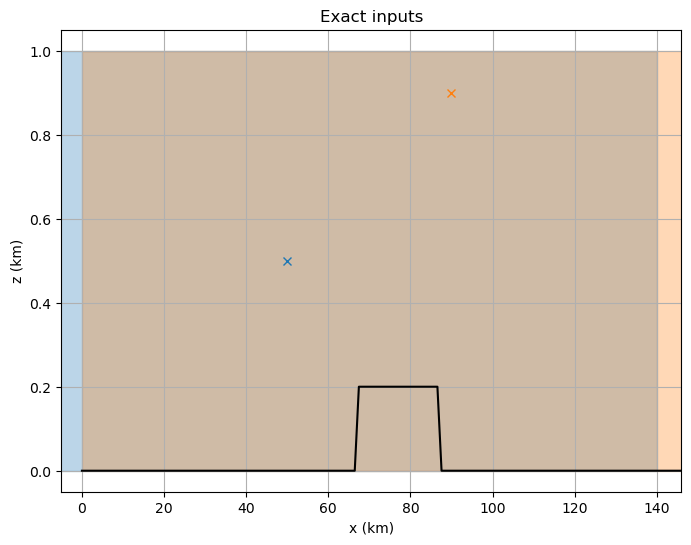

In [52]:
# plot "domain" (to improve)

# Plot captors location
xCapt = np.array(captors)[:,0]*Nx/Lx
yCapt = np.array(captors)[:,1]

# "Area of information" = simulation duration * velocity (here velocity = 1)
deltaX = 18*Nx/Lx 

print(xCapt, yCapt)


# Plot exact input location 
# figIn, axIn = plt.subplots(figsize=(24,4))
figIn, axIn = plt.subplots(figsize=(8, 6))


axIn.plot(xCapt[0],yCapt[0],'x', color="C0")
axIn.plot(xCapt[1],yCapt[1],'x', color="C1")
axIn.add_patch(plt.Rectangle((xCapt[0]-deltaX,0), deltaX*2, 1, color="C0", alpha=0.3))
axIn.add_patch(plt.Rectangle((xCapt[1]-deltaX,0), deltaX*2, 1, color="C1", alpha=0.3))

exact_full = fill_input(exact, fixedFloor)
axIn.plot(np.linspace(0,Nx,Nx)*1, exact_full*0.2, color="k")
axIn.set_title("Exact inputs")
axIn.set_xlabel("x (km)")
axIn.set_ylabel("z (km)")
axIn.set_xlim(-5, 146)
axIn.grid()

[50. 90.] [0.5 0.9]


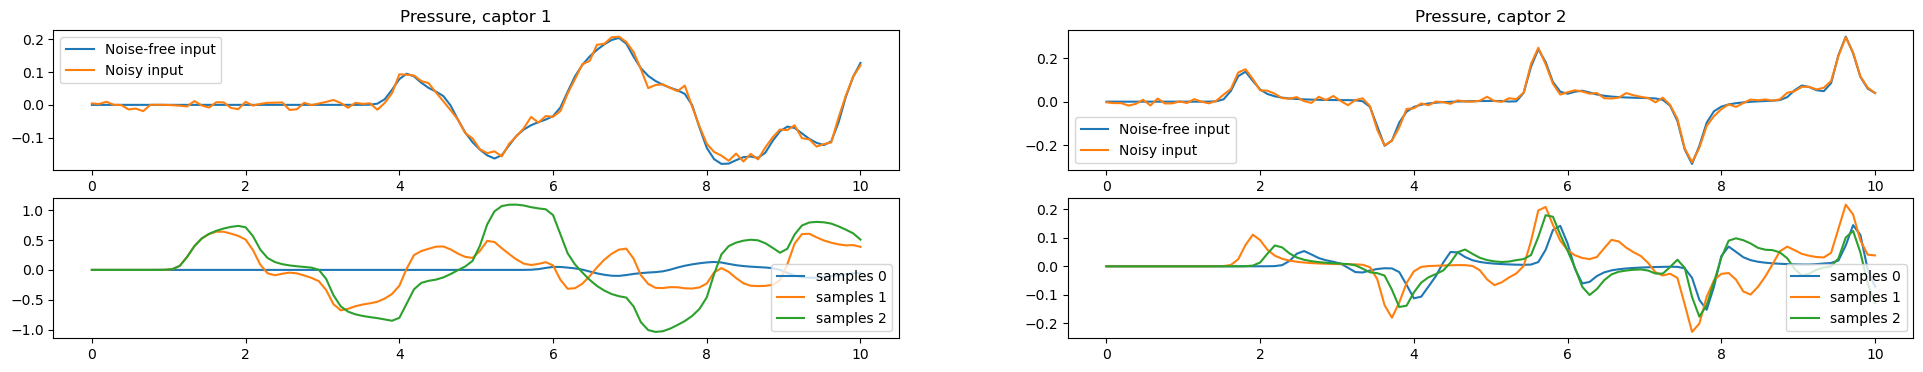

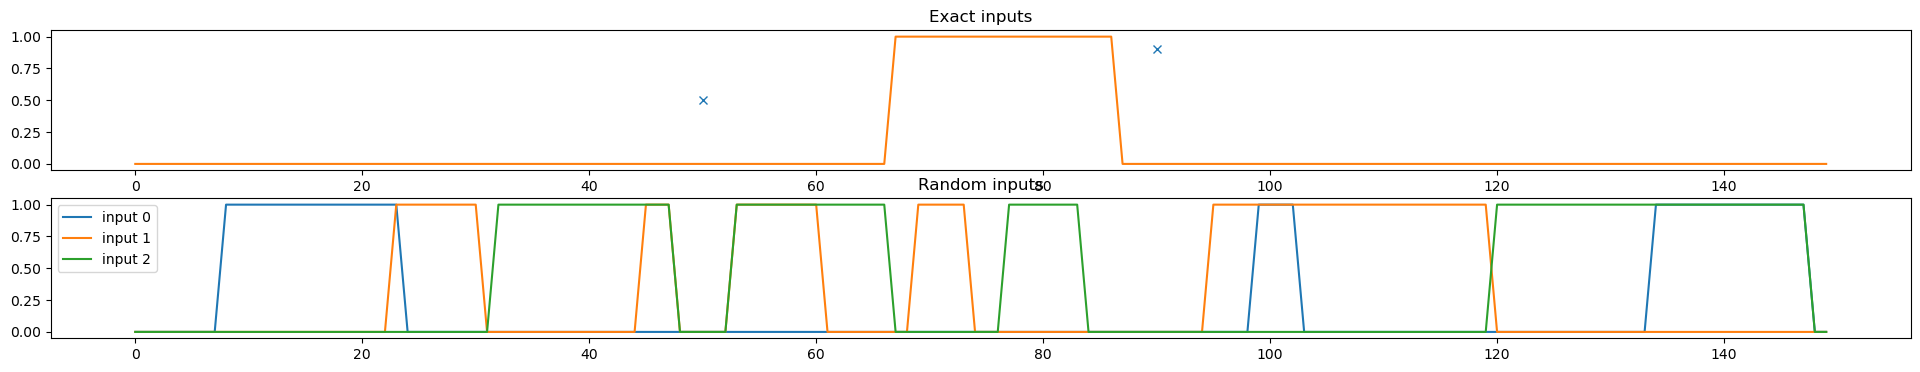

In [11]:
# plot several output and the exact (with/without noise) input/output
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,4))
figIn, axIn = plt.subplots(nrows=2, figsize=(24,4))

# exact (with/without noise) input/output 
xCapt = np.array(captors)[:,0]*Nx/Lx
yCapt = np.array(captors)[:,1]*Nz/Nz
print(xCapt, yCapt)

axIn[0].plot(xCapt,yCapt,'x')
exact_full = fill_input(exact, fixedFloor)
axIn[0].plot(exact_full)
axIn[0].set_title("Exact inputs")

t = np.linspace(0,10,int(ny/2))
d_true1 = np.array(d_true)[0:ny:2]
d_true2 = np.array(d_true)[1:ny:2]

d1 = np.array(d)[0:ny:2]
d2 = np.array(d)[1:ny:2]

ax[0][0].set_title('Pressure, captor 1')
ax[0][0].plot(t,d_true1, label='Noise-free input')
ax[0][0].plot(t,d1, label='Noisy input')
ax[0][0].legend()

ax[0][1].set_title('Pressure, captor 2')
ax[0][1].plot(t,d_true2, label='Noise-free input')
ax[0][1].plot(t,d2, label='Noisy input')
ax[0][1].legend()


# Plot several random samples
samples = []
inputs=[]
for x in range(3):
     log = my_prior.rvs()
     log = restriction(log)
     d_sample = my_model(log)

     d_sample1 = np.array(d_sample)[0:ny:2]
     d_sample2 = np.array(d_sample)[1:ny:2]
     
     ax[1][0].plot(t, d_sample1, label=f'samples {x}')
     ax[1][1].plot(t, d_sample2, label=f'samples {x}')

     log_full = fill_input(log,fixedFloor)
     axIn[1].plot(range(len(log_full)), log_full, label=f'input {x}')
     samples.append(d_sample)
     inputs.append(log)

ax[1][0].legend()
ax[1][1].legend()
axIn[1].set_title("Random inputs")
axIn[1].legend()

plt.show()

## Set up log-likelihood

Test standard Gaussian log-likelihood:
$$\log ⁡L(x)=-0.5(x-y)^T\Sigma^{-1}(x−y)$$

with a Wasserstein-2-based log-likelihood as in Dunlop+Yang, 2021:
$$\log ⁡L(x)\propto -\lambda W_2(x,y),$$

where:
- x = model output
- y = ground truth
- λ = scale parameter (e.g. inverse covariance)

While $W_1$ is contained in scipy.stats it seems $W_2$ is not

In [19]:
class WassersteinLoglike:
    """
    Wasserstein-2 based log-likelihood
    """

    def __init__(self, data, lam=1.0):
        """
        Parameters
        ----------
        data : np.ndarray
            ground truth.
        lam : float
            Scaling factor (like inverse variance).
        """
        self.data = np.sort(data)
        self.lam = lam

    def loglike(self, x):
        """
        Compute the log-likelihood using squared W₂ distance.
        
        Parameters
        ----------
        x : np.ndarray
            Model output (same shape as data).
        
        Returns
        -------
        float
            Log-likelihood (unnormalized).
        """
        x_sorted = np.sort(x)
        return -self.lam * np.mean((x_sorted - self.data) ** 2)

    def grad_loglike(self, x):
        """
        Gradient of the W₂ log-likelihood.
        
        Returns
        -------
        np.ndarray
            Gradient of the log-likelihood.
        """
        n = len(x)
        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_sorted = self.data

        grad_sorted = -2 * self.lam * (x_sorted - y_sorted) / n

        grad = np.zeros_like(x)
        grad[sort_idx] = grad_sorted
        return grad
    
# Test for Gaussian log like
#sigma = 2.0
#cov_likelihood = sigma**2*np.eye(d_true.shape[0])
#my_loglike = tda.GaussianLogLike(d_true, cov_likelihood)

# Test for Wasserstain based log like
# TODO move implementation into tinyDA
my_loglike = WassersteinLoglike(d_true, 100.0)

In [20]:
print("true ", np.exp(my_loglike.loglike(d_true)))
print("true + small noise ", np.exp(my_loglike.loglike(d)))

for d_sample in samples:
    print(np.exp(my_loglike.loglike(d_sample)))

true  1.0
true + small noise  0.996480630855681
0.8602230640142601
0.07985980107600436
1.3783387540134828e-05


In [21]:
# initialise the Posterior
def levelset_model(parameters):
    levelset_params = restriction(parameters)
    return my_model(levelset_params)

my_posterior = tda.Posterior(my_prior, my_loglike, levelset_model)
#my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

### Set up the proposal

In [22]:
# Custom Crank-Nicolson with cutoff and levelset
class CrankNicolson(tda.CrankNicolson):
    def __init__(self, scaling, adaptive):
        super().__init__(scaling=scaling, adaptive=adaptive)

    def make_proposal(self, link):
        # make a pCN proposal.
        self.scaling = min(self.scaling, 1.0 - 1e-3)
        return np.sqrt(
            1 - self.scaling**2
        ) * link.parameters + self.scaling * np.random.multivariate_normal(
            self._mean, self.C
        )

# preconditioned Crank-Nicolson
pcn_scaling = 0.15
pcn_adaptive = True
my_proposal = CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# # random walk Metropolis
#rwmh_cov = np.eye(nx)
#rmwh_scaling = 0.1
#rwmh_adaptive = False
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

### Sample

In [ ]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=6000, n_chains=2, force_sequential=True)

### Get some diagnostics

In [7]:
import arviz as az

In [40]:
# convert the tinyDA chains to an ArViz InferenceData object.
burnin = 1000
#idata = tda.to_inference_data(my_chains, burnin=burnin)
#az.to_netcdf(idata, "results_wassersteinlog.nc") # to store
idata = az.from_netcdf("results_wassersteinlog.nc")# to load

/home/anne/.local/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [41]:
print(idata)
print(idata.sample_stats)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> qoi
<xarray.Dataset> Size: 280kB
Dimensions:     (chain: 2, draw: 5001)
Coordinates:
  * chain       (chain) int64 16B 0 1
  * draw        (draw) int64 40kB 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999 5000
Data variables:
    prior       (chain, draw) float64 80kB ...
    likelihood  (chain, draw) float64 80kB ...
    posterior   (chain, draw) float64 80kB ...


In [42]:
# display posterior summary statistics.
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", None)
info = az.summary(idata);
info

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,-0.020,1.009,-1.940,1.856,0.027,0.019,1426.0,1594.0,1.0
x1,-0.019,1.012,-1.868,1.938,0.027,0.019,1363.0,1590.0,1.0
x2,-0.017,1.013,-1.980,1.835,0.028,0.020,1322.0,1530.0,1.0
x3,-0.014,1.013,-1.902,1.872,0.028,0.020,1294.0,1435.0,1.0
x4,-0.010,1.011,-1.838,1.842,0.028,0.020,1296.0,1073.0,1.0
x5,-0.004,1.007,-1.677,1.924,0.028,0.020,1304.0,1240.0,1.0
x6,0.004,1.001,-1.807,1.807,0.028,0.019,1324.0,1206.0,1.0
x7,0.015,0.996,-1.754,1.903,0.027,0.019,1362.0,1819.0,1.0
x8,0.027,0.993,-1.956,1.752,0.027,0.019,1408.0,1808.0,1.0
x9,0.043,0.995,-1.828,1.921,0.026,0.018,1466.0,1445.0,1.0


/home/anne/.local/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (136), generating only 20 plots
  warnings.warn(


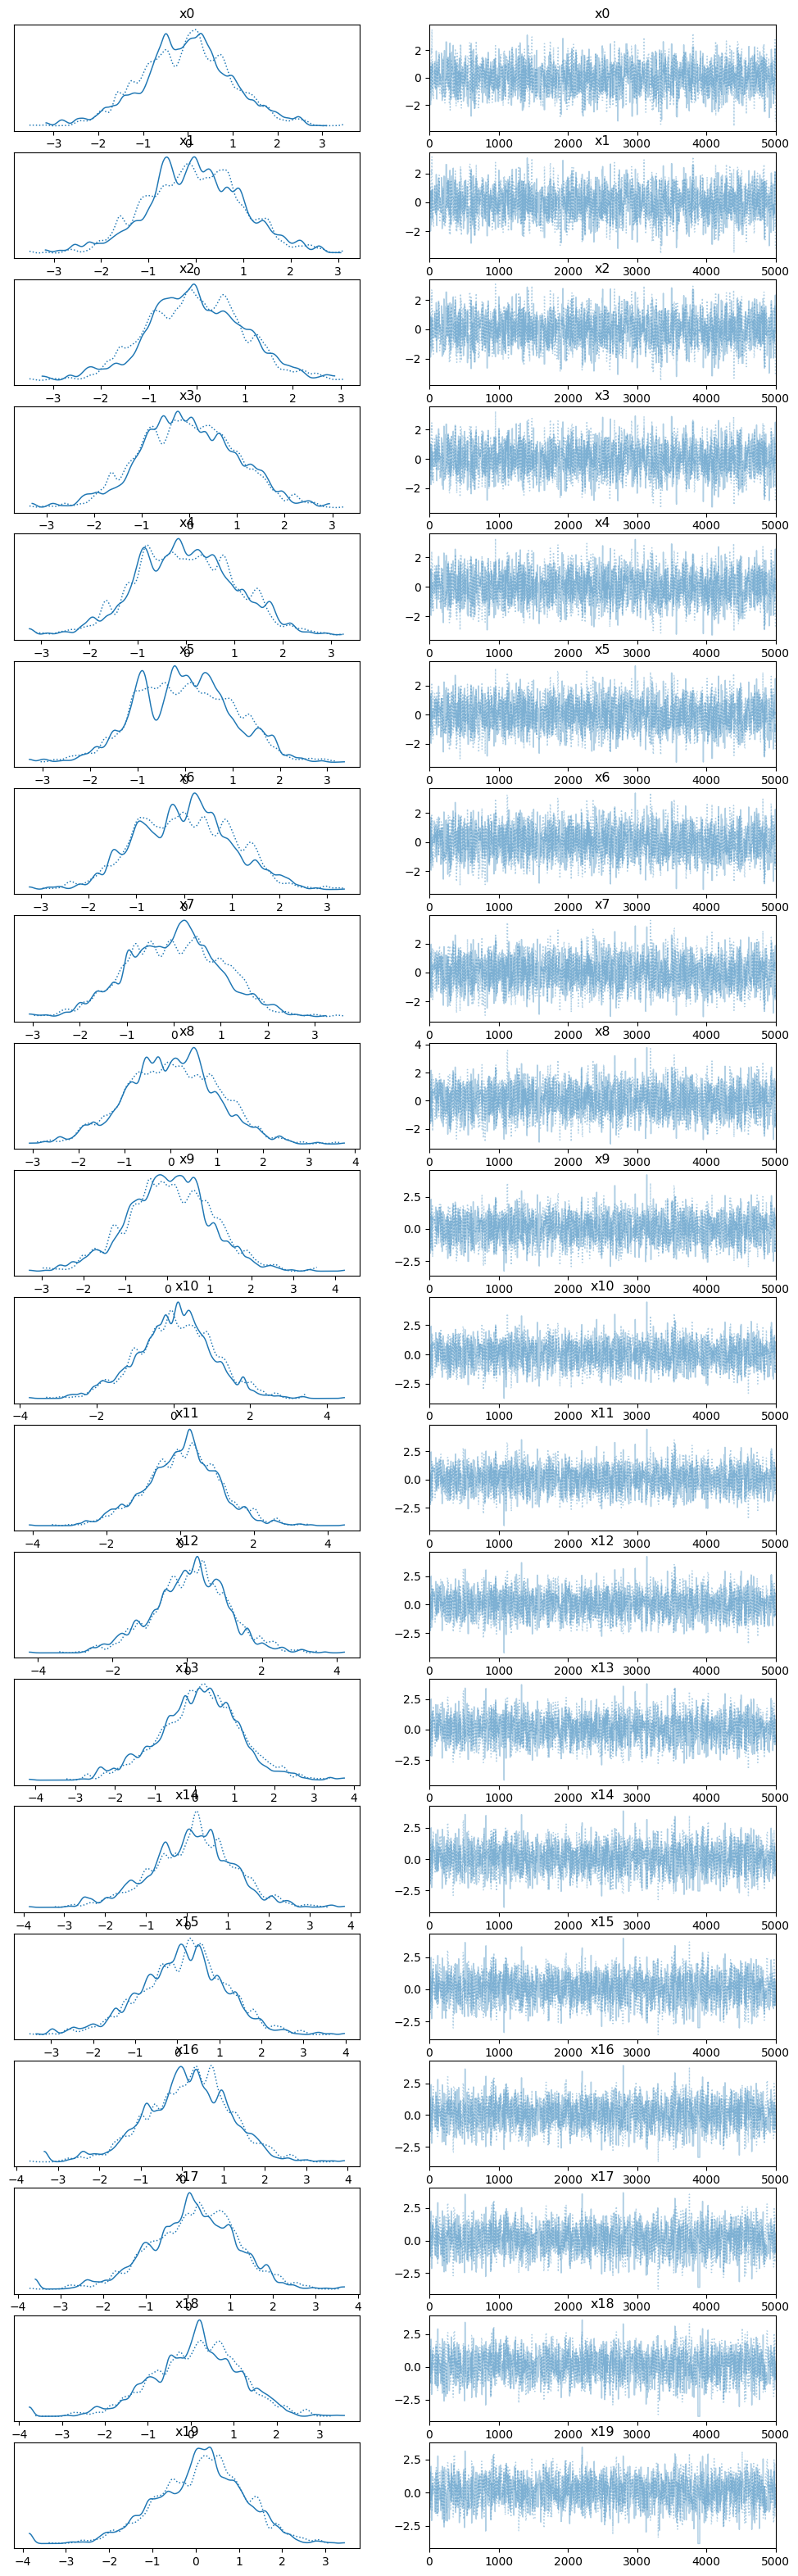

In [36]:
# plot posterior kernel densities and traces.
az.plot_trace(idata)
plt.show()

In [63]:
# extract the parameters from the chains.
subsampling_rate = 20
burnin = 2000
#parameters = [link.parameters for link in my_chains['chain_0'][burnin::subsampling_rate] + my_chains['chain_1'][burnin::subsampling_rate]]

# If loaded data need to do this, otherwise above is easier
idata_sub = idata.sel(draw=slice(burnin, None, subsampling_rate))
parameters = []
for i in range(idata_sub.posterior.draw.size):
    parameters = [
        np.array([idata_sub.posterior[var].values[0, i] for var in idata_sub.posterior.data_vars])
        for i in range(idata_sub.posterior.draw.size)
    ]

In [61]:
n_samples = 100
ids = np.random.randint(0, len(parameters), n_samples)

# Evaluate model outputs and likelihoods
likelihoods = []
outputs = []

for i in ids:
    param = parameters[i]
    output = levelset_model(param)
    outputs.append(output)
    idata_sub = idata.sel(draw=slice(None, None, subsampling_rate))
    loglikes = idata_sub.sample_stats["likelihood"].values.flatten()
    #print("Likelihood ", loglikes[i])
    likelihoods.append(loglikes[i])

# Normalize likelihoods for colormap
likelihoods = np.array(likelihoods)
norm = colors.Normalize(vmin=np.min(likelihoods), vmax=np.max(likelihoods))
cmap = cm.viridis  # Or any matplotlib colormap
colors_list = [cmap(norm(l)) for l in likelihoods]

KeyboardInterrupt: 

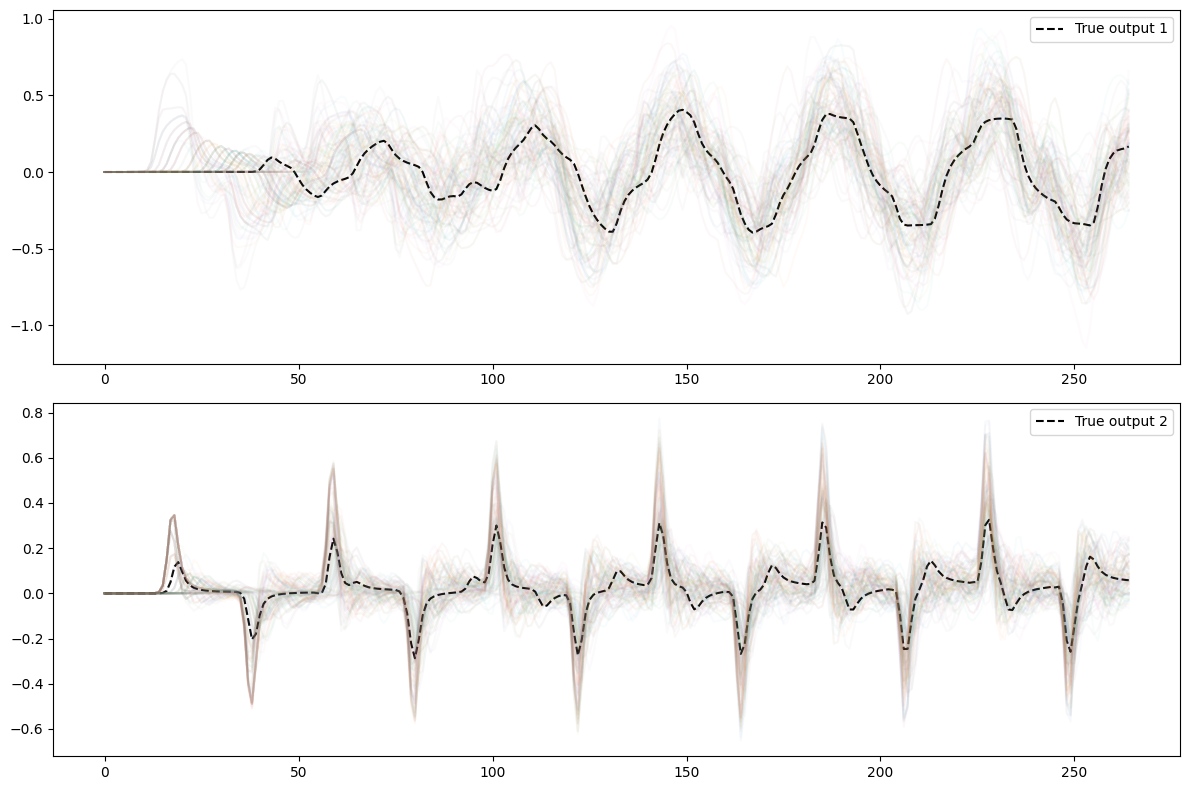

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

d_true = np.array(d_true)
ax[0].plot(d_true[::2], 'k--', label="True output 1")
ax[1].plot(d_true[1::2], 'k--', label="True output 2")
for output in outputs:
    ax[0].plot(output[::2], alpha=0.03)
    ax[1].plot(output[1::2], alpha=0.03)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

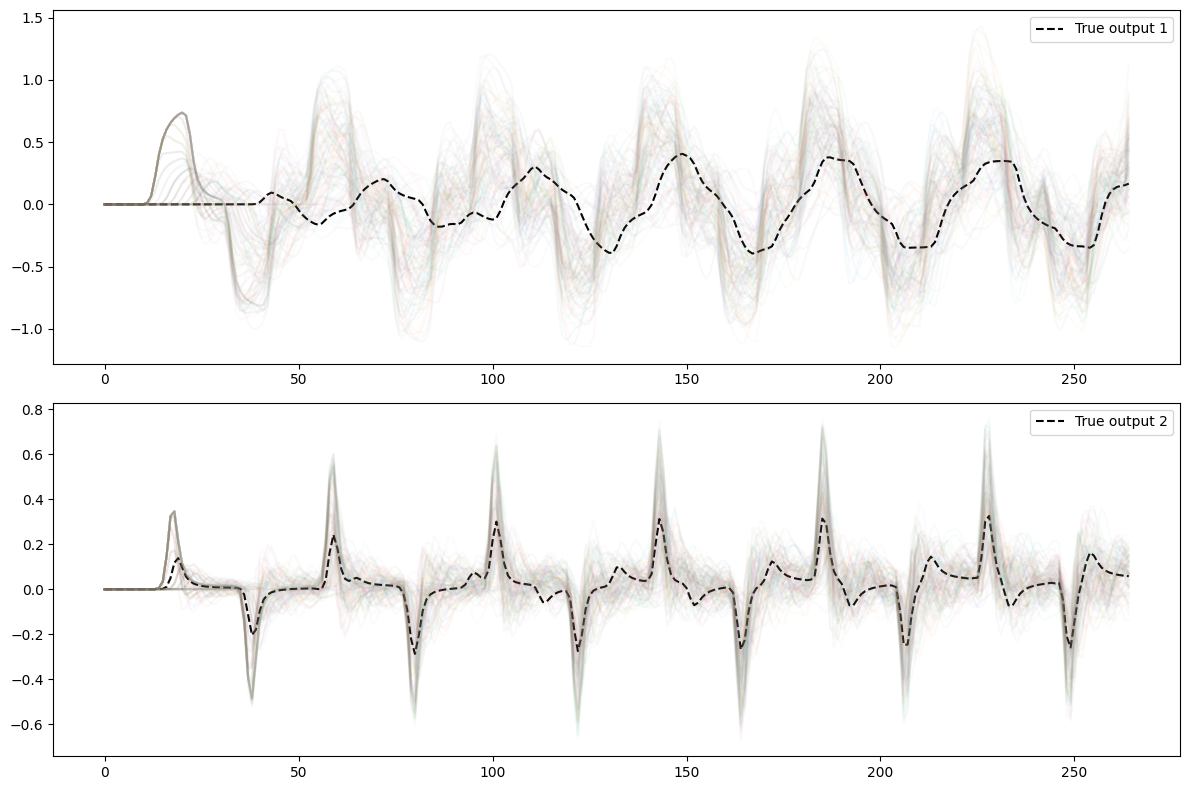

In [50]:
n_samples = 100

# Evaluate model outputs and likelihoods
likelihoods = []
outputs = []

# Compare with draws from the prior
for ids in range(n_samples):
    log = my_prior.rvs()
    log = restriction(log)
    output = levelset_model(log)
    outputs.append(output)
    idata_sub = idata.sel(draw=slice(None, None, subsampling_rate))
    loglikes = idata_sub.sample_stats["likelihood"].values.flatten()
    likelihoods.append(loglikes[i])

# Normalize likelihoods for colormap
likelihoods = np.array(likelihoods)
norm = colors.Normalize(vmin=np.min(likelihoods), vmax=np.max(likelihoods))
cmap = cm.viridis  # Or any matplotlib colormap
colors_list = [cmap(norm(l)) for l in likelihoods]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

d_true = np.array(d_true)
ax[0].plot(d_true[::2], 'k--', label="True output 1")
ax[1].plot(d_true[1::2], 'k--', label="True output 2")
for output in outputs:
    ax[0].plot(output[::2], alpha=0.03)
    ax[1].plot(output[1::2], alpha=0.03)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

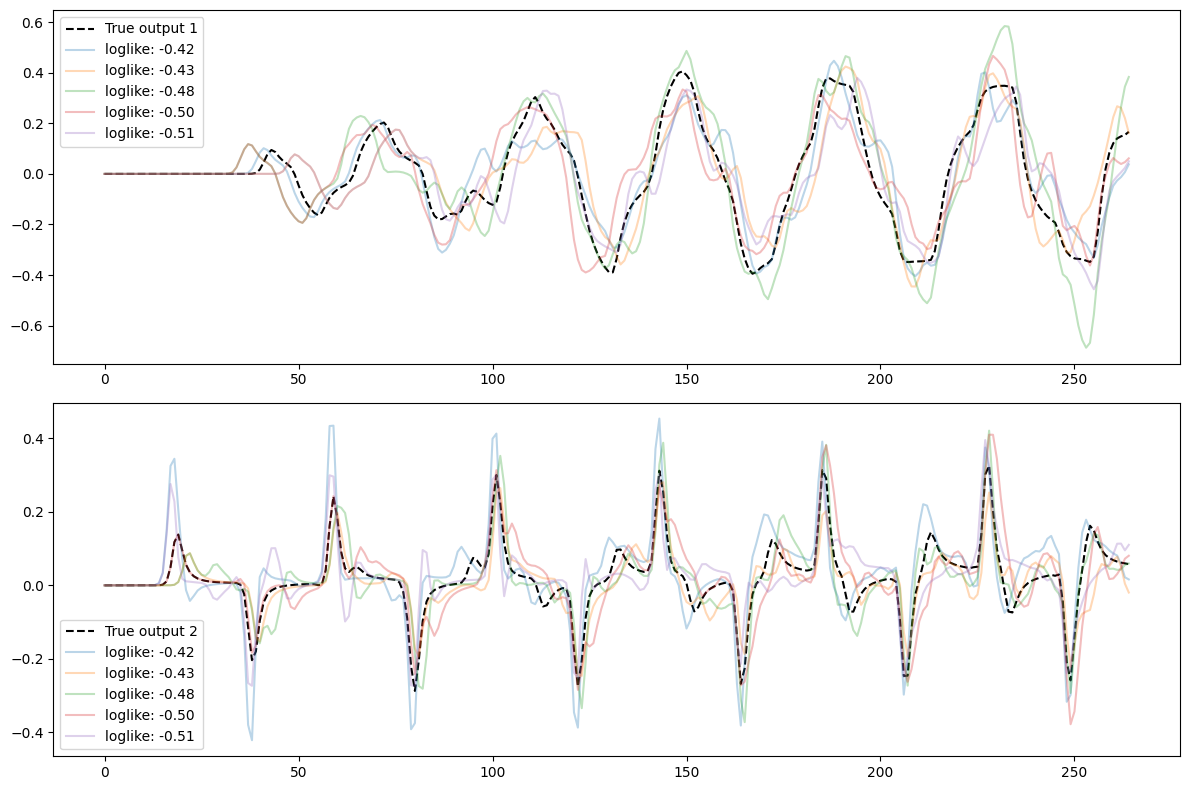

In [54]:
# Extract corresponding likelihoods
likelihoods = idata_sub.sample_stats["likelihood"].values[0, :]

# Sort parameter sets by decreasing likelihood
sorted_indices = np.argsort(-likelihoods)  # Negative for descending order
top_indices = sorted_indices[:5]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

d_true = np.array(d_true)
ax[0].plot(d_true[::2], 'k--', label="True output 1")
ax[1].plot(d_true[1::2], 'k--', label="True output 2")

for i in top_indices:
    param = parameters[i]
    output = np.array(levelset_model(param))
    loglike = likelihoods[i]
    ax[0].plot(output[::2], alpha=0.3, label=f"loglike: {loglike:.2f}")
    ax[1].plot(output[1::2], alpha=0.3, label=f"loglike: {loglike:.2f}")

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

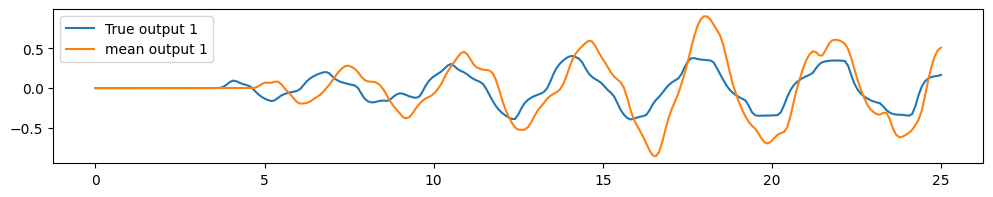

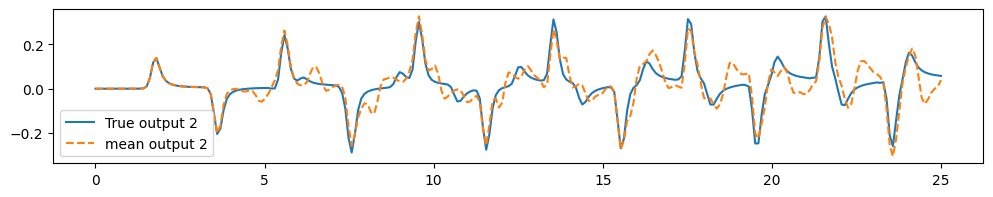

In [64]:
x=np.linspace(0,nx, nx)
t=np.linspace(0,25, int(ny/2))
d1 = np.array(d_true)[0:ny:2]
d2 = np.array(d_true)[1:ny:2]

output = levelset_model(info['mean'])
o1 = np.array(output)[0:ny:2]
o2 = np.array(output)[1:ny:2]

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(t,d1, label='True output 1')
ax.plot(t,o1, label='mean output 1')
ax.legend()

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(t,d2, label='True output 2')
ax.plot(t,o2, '--' ,label='mean output 2')
ax.legend()

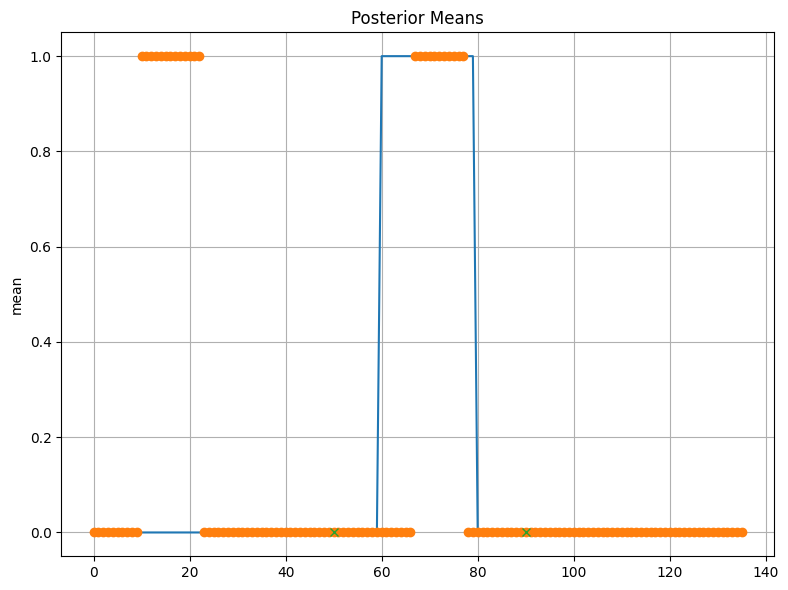

In [70]:
x = range(len(info))
plt.figure(figsize=(8, 6))
plt.plot(exact)
plt.title('Exact input')
eps = 5e-2
plt.plot(x, restriction(info['mean']), 'o')  # x = index, y = mean
#plt.plot(x, info['mean'], 'x')  # x = index, y = mean
#print(top_links[0])
#plt.plot(x, restriction(parameters[top_indices[0]]), 'x')  # x = index, y = mean
plt.plot([captors[0][0]*Nx/Lx,captors[1][0]*Nx/Lx],[0,0],'x')
plt.ylabel('mean')
plt.title('Posterior Means')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_autocorr(idata);

In [ ]:
az.plot_posterior(idata);

In [ ]:
az.plot_rank(idata);

## Sequential Monte Carlo

Adjustments:
- replace manual logging with arvis inference structure (easier/faster saving in netcdf format, immediate access to plotting routines)
- replace prior class with scipy priors (compatibility with tinyDA code above)
- replace loglikelihood class with tinyDA style loglikelihood
- replace MCMC steps with tinyDA

In [16]:
from os import sys, path, getcwd
sys.path.append(path.dirname(getcwd()))

import functools as ft

import warnings
import matplotlib.cbook
import scipy.stats as stats

from SMC import *

Finished: Wed Jul 30 16:08:34 2025


Start with the example provided before moving on to more complex model

In [51]:
### M:  number of particles/samples for SMC
num_samples = 10

### var: uncertainty variance of measurements/modeling
std_noise = 0.05

### Title for saving the results
run = "acousticgravity"  # or any identifier you want
resultspath = f'RESULTS/SMC_M_{num_samples}_{run}'

In [52]:
# Wrapper for scipy prior
class prior:
    def __init__(self, prior, d = 1):
        self.d = d # dimension of prior/parameter space, here 1
        self.RV = prior # this is specific to this prior

    def rvs(self, M):
        # Generate n samples. The resulting numpy array must be [1:d, 1:M]
        return np.array([self.RV.rvs(size=M) for i in range(self.d)])

    def logpdf(self, particle):
        # Compute logpdf at a point "particle"-
        return np.sum([self.RV.logpdf(particle[i]) for i in range(self.d)])

nx = 1 # 1D test case just to start!
length_scale = 5.0
eps = 1e-6
decay_rate = 10

x = np.linspace(0, nx - 1, nx).reshape(-1, 1)
def rbf_covariance(grid, length_scale, variance=1.0):
    dists = cdist(grid, grid, 'euclidean')
    return variance * np.exp(-0.5 * (dists / length_scale) ** 2)

cov = rbf_covariance(x, length_scale)
cov += eps * np.eye(nx)
mean = np.zeros(nx)
my_prior = prior(stats.multivariate_normal(mean=mean, cov=cov), d=1)

In [53]:
### Set up forward model
def forward_model(x0):
    #Transform x0 to single location in input parameter vector (simplified testcase, to be replaced later)
    # True x0 is 70
    nx = umbridge_model.get_input_sizes(config)[0]
    xvec = np.zeros(nx)
    if 0 <= x0[0] - 10 < nx: xvec[int(x0[0]) - 10] = 1
    if 0 <= x0[0] + 10 < nx: xvec[int(x0[0]) + 10] = 1
    output = levelset_model(xvec)   
    return output

def potential(particle, data, std_noise = 0.05):
    fwd_vals = forward_model(particle)
    #return 1.*(np.linalg.norm(fwd_vals-data)**2/(2.*std_noise**2)) 
    return my_loglike.loglike(fwd_vals)

# Multiprocessing evaluation of previous potential 
def potential_mp(particles,data, std_noise = 0.05):
    pool = mp.Pool()
    potentials = pool.map(ft.partial(potential, data=data, std_noise=std_noise),particles.T)
    pool.close()
    return np.array(potentials)


In [54]:
### SET UP SMC SAMPLER  
SMC_sampler = SMC(my_prior, lambda x: potential_mp(x, data = d_true, std_noise = std_noise), resultspath, d_true, num_samples)
SMC_sampler.smc_tempering() ### perform SMC algorithm

SMC for RESULTS/SMC_M_10_acousticgravity - Started: Wed Jul 30 16:20:34 2025
------ TEMPERING-STEP 0 --------------------------

>> REWEIGHTED with exponent 1.0
>> NOT resampled (ESS 99.99% , exponent = 1)

--- duplicates: 0/10  |  highest count: 1x
Applying MCMC kernel 4 times 

Acceptance ratio: 0.8 >0.3 
  => variance scaling: 1.0->2.0
>> MCMC complete!
--- duplicates: 0/10  |  highest count: 1x
[saved intermediate result]
Tempering finished!
Tempering steps done:  0
